In [1]:
import pandas as pd
import json
from tqdm import tqdm
from pathlib import Path
cwd = Path('.')

In [2]:
'''Read in Raw Data: Comments.csv'''

comments_df= pd.read_csv(cwd/'output'/'comments.csv',usecols = [0,1], error_bad_lines=False)
videos_df=pd.read_csv(cwd/'output'/'videos.csv', usecols = [0,3], error_bad_lines=False)
comments_df=pd.merge(comments_df, videos_df, on='video_id',how='left')
comments_df.drop_duplicates(inplace=True)

comments_df.head(5)

,video_id,comment_text,category_id
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,24
14,XpVt6Z1Gjjo,I've been following you from the start of your...,24
28,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,24
42,XpVt6Z1Gjjo,MY FAN . attendance,24
56,XpVt6Z1Gjjo,trending 😉,24


In [3]:
'''get training category ids'''
with open(cwd/'data_scraper'/'kaggle'/'GB_category_id.json') as json_file:
    gb_json = json.load(json_file)

id_to_category = {}
for i in gb_json['items']:
    category = i['snippet']['title']
    id = int(i['id'])
    id_to_category[id] = category
training_id = []
for i in id_to_category:
    training_id.append(i)

In [4]:
comments_df

,video_id,comment_text,category_id
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,24
14,XpVt6Z1Gjjo,I've been following you from the start of your...,24
28,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,24
42,XpVt6Z1Gjjo,MY FAN . attendance,24
56,XpVt6Z1Gjjo,trending 😉,24
...,...,...,...
10590500,lLN1FwiqGwc,*Gasp*\n*Gasp* \nGASP!,24
10590528,lLN1FwiqGwc,"Yeah, but does everybody float?",24
10590542,lLN1FwiqGwc,That meme me dace 😂,24
10590556,lLN1FwiqGwc,10:43 Is that Miles Upshur????,24


In [5]:
comments_df['comment_text'] = comments_df['comment_text'].apply(str)

In [6]:
df = comments_df.groupby('category_id')['comment_text'].apply(list)

In [7]:
df = df.reset_index()

In [8]:
df = df.dropna()

In [9]:
df['comment_text'].dtype

dtype('O')

In [10]:
df['comments'] = df.apply(lambda row: " ".join(row['comment_text']), axis=1)

In [11]:
df['category'] = df['category_id'].map(id_to_category)
df['id'] = df['category_id']
df = df[['id', 'category', 'comments']]

In [12]:
df=df.loc[[0,1,2,3,4,6,7,9,10,11,12,13,14,15]]

In [13]:
df

,id,category,comments
0,1,Film & Animation,I'm sure I speak for everyone when I say the w...
1,2,Autos & Vehicles,"Imagine if Bernie was president,\n\n\n\n\n\n😃😃..."
2,10,Music,Trash and I like fergie but this shit is not g...
3,15,Pets & Animals,How does Mugumogu not collapse in a heap of la...
4,17,Sports,Wow I know these are just highlights but wow t...
6,20,Gaming,Yellow fever Parker & (((Stone))) revealed who...
7,22,People & Blogs,Love you Pewdiepie don't apologize your fine I...
9,24,Entertainment,Logan Paul it's yo big day ‼️‼️‼️ I've been fo...
10,25,News & Politics,"I got hit by Hurricane Irma too, but it wasn't..."
11,26,Howto & Style,Did he just say chang-jangle?? What happened t...


# Cleaning the text

In [14]:
import re
import string

df['comments'] = df['comments'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
'''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers'''
def clean_text(text):
    text= text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*','',text)
    return text
clean1= lambda x: clean_text(x)


df_clean = pd.DataFrame (df['comments'].apply(clean1))
df_clean['category'] = df['category']
df_clean=df_clean[['category','comments']]


In [15]:
df_clean

,category,comments
0,Film & Animation,im sure i speak for everyone when i say the wa...
1,Autos & Vehicles,imagine if bernie was presidentnnnnnn i used t...
2,Music,trash and i like fergie but this shit is not g...
3,Pets & Animals,how does mugumogu not collapse in a heap of la...
4,Sports,wow i know these are just highlights but wow t...
6,Gaming,yellow fever parker stone revealed who they r...
7,People & Blogs,love you pewdiepie dont apologize your fine i ...
9,Entertainment,logan paul its yo big day ive been following ...
10,News & Politics,i got hit by hurricane irma too but it wasnt a...
11,Howto & Style,did he just say changjangle what happened to w...


In [16]:
'''Produce a document term matrix of words for each category '''
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(df_clean.comments)
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data_dtm['category'] = df_clean['category']
data_dtm = data_dtm.set_index('category')
data_dtm

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,...,𝕡𝕣𝕠𝕞𝕠,𝘾𝙝𝙚𝙘𝙠,𝙊𝙪𝙧,𝙘𝙤𝙤𝙡,𝙙𝙚𝙖𝙡𝙨,𝙙𝙞𝙨𝙘𝙤𝙪𝙣𝙩,𝙤𝙪𝙩,𝙨𝙝𝙞𝙥𝙨,𝙬𝙖𝙧𝙚𝙝𝙤𝙪𝙨𝙚,𝙬𝙞𝙩𝙝
category,,,,,,,,,,,,,,,,,,,,,
Film & Animation,0,3,0,1,2,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
Autos & Vehicles,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,82,50,17,15,10,9,10,1,5,5,...,0,0,0,0,0,0,0,0,0,0
Pets & Animals,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Sports,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,4,17,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gaming,5,2,6,2,2,3,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
People & Blogs,13,10,6,2,5,5,3,3,1,2,...,0,0,0,0,0,0,0,0,0,0
NaN,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Let's visualize the results

In [17]:
# NUMBER 1 : WORD MAPPP
data=data_dtm.transpose()
data.head()

category,Film & Animation,Autos & Vehicles,Music,Pets & Animals,Sports,NaN,Gaming,People & Blogs,NaN,Entertainment,News & Politics,Howto & Style,Education,Science & Technology
aa,0,1,82,1,4,4,5,13,1,1,3,3,0,0
aaa,3,2,50,0,1,17,2,10,1,1,1,2,0,0
aaaa,0,0,17,0,1,0,6,6,0,2,0,0,0,0
aaaaa,1,0,15,1,0,1,2,2,0,0,0,0,0,0
aaaaaa,2,0,10,0,0,0,2,5,0,1,0,1,0,0


In [18]:
'''Create dictionary to count top 30 words in each category'''
top_dict = {}
for c in data.columns:
    try:
        top = data[c].sort_values(ascending = False).head(30)
        top_dict[c] = list(zip(top.index, top.values))
    except:
        continue
top_dict

{'Film & Animation': [('like', 2849),
  ('movie', 2686),
  ('just', 2069),
  ('im', 1657),
  ('love', 1396),
  ('video', 1243),
  ('dont', 1176),
  ('good', 1141),
  ('know', 1021),
  ('looks', 996),
  ('really', 989),
  ('people', 952),
  ('make', 920),
  ('time', 869),
  ('say', 867),
  ('think', 856),
  ('trailer', 843),
  ('did', 819),
  ('great', 730),
  ('want', 725),
  ('watch', 677),
  ('rick', 654),
  ('new', 622),
  ('lol', 614),
  ('wrong', 606),
  ('got', 592),
  ('thats', 552),
  ('going', 538),
  ('way', 519),
  ('film', 517)],
 'Autos & Vehicles': [('car', 648),
  ('like', 481),
  ('video', 398),
  ('just', 371),
  ('make', 281),
  ('cars', 205),
  ('good', 200),
  ('im', 199),
  ('engine', 191),
  ('love', 190),
  ('dont', 183),
  ('really', 160),
  ('know', 159),
  ('great', 155),
  ('time', 154),
  ('pilot', 148),
  ('videos', 145),
  ('way', 143),
  ('thats', 140),
  ('work', 138),
  ('did', 136),
  ('going', 136),
  ('think', 135),
  ('people', 125),
  ('new', 125),

In [19]:
words = []

for category in data.columns:
    try:
        top = [word for (word, count) in top_dict[category]]
    except:
        # some categories has less than 30 top words
        pass
    for t in top:
        words.append(t)
words   

['like',
 'movie',
 'just',
 'im',
 'love',
 'video',
 'dont',
 'good',
 'know',
 'looks',
 'really',
 'people',
 'make',
 'time',
 'say',
 'think',
 'trailer',
 'did',
 'great',
 'want',
 'watch',
 'rick',
 'new',
 'lol',
 'wrong',
 'got',
 'thats',
 'going',
 'way',
 'film',
 'car',
 'like',
 'video',
 'just',
 'make',
 'cars',
 'good',
 'im',
 'engine',
 'love',
 'dont',
 'really',
 'know',
 'great',
 'time',
 'pilot',
 'videos',
 'way',
 'thats',
 'work',
 'did',
 'going',
 'think',
 'people',
 'new',
 'looks',
 'does',
 'got',
 'use',
 'shit',
 'love',
 'song',
 'like',
 'im',
 'just',
 'video',
 'music',
 'good',
 'dont',
 'amazing',
 'know',
 'beautiful',
 'great',
 'really',
 'best',
 'new',
 'voice',
 'time',
 'got',
 'que',
 'songs',
 'make',
 'think',
 'people',
 'album',
 'better',
 'omg',
 'fuck',
 'way',
 'shit',
 'like',
 'love',
 'just',
 'cat',
 'video',
 'coyote',
 'im',
 'dog',
 'dont',
 'spider',
 'cute',
 'know',
 'amazing',
 'beautiful',
 'cats',
 'good',
 'really

In [20]:
'''Show words which appear most commonly across categories'''

from collections import Counter
Counter(words).most_common()

[('like', 14),
 ('just', 14),
 ('im', 13),
 ('love', 13),
 ('video', 13),
 ('good', 13),
 ('know', 13),
 ('think', 13),
 ('great', 13),
 ('dont', 12),
 ('really', 12),
 ('people', 12),
 ('make', 12),
 ('time', 12),
 ('did', 11),
 ('got', 10),
 ('lol', 8),
 ('way', 8),
 ('looks', 7),
 ('want', 7),
 ('thats', 7),
 ('going', 6),
 ('shit', 6),
 ('best', 6),
 ('videos', 5),
 ('amazing', 5),
 ('fuck', 5),
 ('new', 4),
 ('better', 4),
 ('man', 4),
 ('look', 4),
 ('movie', 3),
 ('say', 3),
 ('watch', 3),
 ('use', 3),
 ('beautiful', 3),
 ('que', 3),
 ('team', 3),
 ('thank', 3),
 ('need', 3),
 ('work', 2),
 ('does', 2),
 ('omg', 2),
 ('game', 2),
 ('hes', 2),
 ('ik', 2),
 ('fan', 2),
 ('win', 2),
 ('guy', 2),
 ('youre', 2),
 ('ive', 2),
 ('apple', 2),
 ('trailer', 1),
 ('rick', 1),
 ('wrong', 1),
 ('film', 1),
 ('car', 1),
 ('cars', 1),
 ('engine', 1),
 ('pilot', 1),
 ('song', 1),
 ('music', 1),
 ('voice', 1),
 ('songs', 1),
 ('album', 1),
 ('cat', 1),
 ('coyote', 1),
 ('dog', 1),
 ('spider', 1)

In [21]:
'''Make stop words include those words which appear most commonly in over half the categories'''

add_stop_words = [word for word, count in Counter(words).most_common() if count > 7]
add_stop_words

['like',
 'just',
 'im',
 'love',
 'video',
 'good',
 'know',
 'think',
 'great',
 'dont',
 'really',
 'people',
 'make',
 'time',
 'did',
 'got',
 'lol',
 'way']

In [22]:
'''Re-construct the dtm with new stop words'''

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

stop_words = text.ENGLISH_STOP_WORDS.union (add_stop_words)
cv=CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(df_clean.comments)
data_stop = pd.DataFrame (data_cv.toarray(),columns=cv.get_feature_names())

data_stop['category']=df['category']
data_stop = data_stop.set_index('category')
data_stop.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,...,𝕡𝕣𝕠𝕞𝕠,𝘾𝙝𝙚𝙘𝙠,𝙊𝙪𝙧,𝙘𝙤𝙤𝙡,𝙙𝙚𝙖𝙡𝙨,𝙙𝙞𝙨𝙘𝙤𝙪𝙣𝙩,𝙤𝙪𝙩,𝙨𝙝𝙞𝙥𝙨,𝙬𝙖𝙧𝙚𝙝𝙤𝙪𝙨𝙚,𝙬𝙞𝙩𝙝
category,,,,,,,,,,,,,,,,,,,,,
Film & Animation,0,3,0,1,2,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
Autos & Vehicles,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,82,50,17,15,10,9,10,1,5,5,...,0,0,0,0,0,0,0,0,0,0
Pets & Animals,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Sports,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,4,17,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gaming,5,2,6,2,2,3,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
People & Blogs,13,10,6,2,5,5,3,3,1,2,...,0,0,0,0,0,0,0,0,0,0
NaN,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

cat_names = df_clean['category'].tolist()

df_clean.set_index('category',inplace=True)
df_clean.head()

,comments
category,
Film & Animation,im sure i speak for everyone when i say the wa...
Autos & Vehicles,imagine if bernie was presidentnnnnnn i used t...
Music,trash and i like fergie but this shit is not g...
Pets & Animals,how does mugumogu not collapse in a heap of la...
Sports,wow i know these are just highlights but wow t...
Gaming,yellow fever parker stone revealed who they r...
People & Blogs,love you pewdiepie dont apologize your fine i ...
Entertainment,logan paul its yo big day ive been following ...
News & Politics,i got hit by hurricane irma too but it wasnt a...


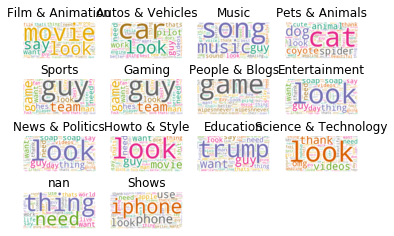

In [24]:
for index, cat in enumerate(data.columns):
    try:
        wc.generate(df_clean.comments[cat])
    except:
        pass
    plt.subplot(4, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(cat_names[index])
    
plt.show()